# Векторизованное тестирование на актуальных исторических данных

Прежде чем запускать данный алгоритм необходимо сначала актуализировать исторические данные. Для этого запускаем QUIK. Затем в QUIK запускаем алгоритм в основе которого лежит функция CreateDataSource, извлекающая данные из графиков движения цены.

В QUIK должны быть запущены стакан с котировками по нужному инструменту, график, таблица текущих торгов. А также скрипты получения данных и отправки транзакций.

# Получение и обработка актуальных данных данных

In [1]:
# Загружаем необходимые библиотеки и классы (treeinterpreter можно
# установить с помощью команды pip install treeinterpreter)
import time
import pickle
import datetime as dt
from pylab import mpl, plt # импорт библиотеки Matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd

In [2]:
plt.style.use('seaborn') # настройка стиля диаграмм
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
# загрузка данных из CSV-файла
# Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
# Если задана последовательность INT / STR, используется многоиндекс.
# Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
# например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
# Функция читает файл, в котором данные о последней свече находятся в первой строке 
raw = pd.read_csv('c:\SBERBANK\QUIK_x64\lua\SiM2\Data\SiM2_Data.csv', index_col=0, parse_dates=False)

In [4]:
raw.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
Index: 3037 entries, 2022-5-13 to 2021-11-24
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    3037 non-null   object 
 1   Open    3037 non-null   float64
 2   High    3037 non-null   float64
 3   Low     3037 non-null   float64
 4   Close   3037 non-null   float64
 5   Volume  3037 non-null   float64
dtypes: float64(5), object(1)
memory usage: 166.1+ KB


In [5]:
# reverse_raw = raw[::-1] # когда берём всю коллекцию целиком
reverse_raw1 = raw[:200] # последние 200 свечей

In [6]:
reverse_raw = reverse_raw1[::-1]

In [7]:
reverse_raw.head()

,Time,Open,High,Low,Close,Volume
Date,,,,,,
2022-4-21,18:30,76426.0,76650.0,76250.0,76599.0,71185.0
2022-4-22,10:0,76687.0,77615.0,75255.0,75314.0,305433.0
2022-4-22,10:30,75314.0,75636.0,75080.0,75222.0,132233.0
2022-4-22,11:0,75222.0,75333.0,74713.0,74836.0,140083.0
2022-4-22,11:30,74838.0,75402.0,74836.0,74900.0,101749.0


In [8]:
reverse_raw.tail()

,Time,Open,High,Low,Close,Volume
Date,,,,,,
2022-5-12,17:0,65407.0,65417.0,64450.0,64581.0,226940.0
2022-5-12,17:30,64573.0,64971.0,64510.0,64875.0,130333.0
2022-5-12,18:0,64879.0,65279.0,64552.0,64552.0,175768.0
2022-5-12,18:30,64557.0,64730.0,64163.0,64237.0,84100.0
2022-5-13,10:0,64458.0,64824.0,63613.0,64701.0,158852.0


In [9]:
reverse_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 2022-4-21 to 2022-5-13
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    200 non-null    object 
 1   Open    200 non-null    float64
 2   High    200 non-null    float64
 3   Low     200 non-null    float64
 4   Close   200 non-null    float64
 5   Volume  200 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.9+ KB


In [10]:
symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close

In [11]:
m5_close = reverse_raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием

In [12]:
# формирование подмножества данных и исключение нечисловых значений (NaN))
data = (pd.DataFrame(m5_close).dropna())

In [13]:
# расчёт логарифмической доходности
data['Доходность'] = np.log(data/data.shift(1))

In [14]:
# всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
data.dropna(inplace=True)

In [15]:
# Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
# Функция astype() преобразует в указанный тип данных, в данном случае int
data['Направление'] = np.sign(data['Доходность']).astype(int)

In [16]:
lags = 5 # поменяли количество 2 на 5

In [17]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Доходность'].shift(lag) # обратить внимание на каком этапе появляются data[col]
        cols.append(col)

In [18]:
create_lags(data)

In [19]:
data.dropna(inplace=True)

In [20]:
# дискретизация значений признаков с учётом параметра bins
def create_bins(data, bins=[0]):
    global cols_bin # объявляем глобальную переменную
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin' # преобразуем названия колонок
        # Функция digitize Возвращает индексы бинов,к которым принадлежит каждое значение во входном массиве.
        # Если значения в x выходят за пределы bins , соответственно возвращается 0 или len(bins). Т.е. отрицательные значения преобразуем в 0, а положительные в 1
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append (col_bin )

In [21]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [22]:
grouped = data.groupby(cols_bin + ['Направление'])
grouped.size() # Отображение частоты возможных движений в зависимости от комбинаций значений признаков

lag_1_bin  lag_2_bin  lag_3_bin  lag_4_bin  lag_5_bin  Направление
0          0          0          0          0          -1             2
                                                        1             4
                                            1          -1             4
                                                        1             2
                                 1          0          -1             5
                                                                     ..
1          1          1          0          1           1             1
                                 1          0          -1             3
                                                        1             2
                                            1          -1             2
                                                        1             7
Length: 62, dtype: int64

In [23]:
# Преобразование объекта DataFrame, чтобы частоты хранились по столбцам.
res = grouped['Направление'].size().unstack(fill_value=0)

In [24]:
# Определение наиболее часто встречающегося значения для каждой комбинации значений признаков.
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [25]:
# Определение наиболее часто встречающегося значения для каждой комбинации значений признаков.
res.style.apply(highlight_max, axis=1)

In [26]:
# Преобразование полученного частотного распределения в торговую стратегию
# Функция where() возвращает элементы, которые могут выбираться из двух массивов в зависимости от условия
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [27]:
(data['Направление'] == data['pos_freq']).value_counts()

True     104
False     90
dtype: int64

In [28]:
data['strat_freq'] = data['pos_freq'] * data['Доходность']

# Обработка данных с помощью алгоритма MLPClassifier

In [29]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)

In [30]:
%time model.fit(data[cols_bin], data['Направление']) 

Wall time: 5.87 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [31]:
# прогнозируем ту колонку, которая нам нужна
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [32]:
data['pos_dnn_sk'].head(10)

Date
2022-4-22   -1
2022-4-22   -1
2022-4-22   -1
2022-4-22   -1
2022-4-22   -1
2022-4-22   -1
2022-4-22    1
2022-4-22    1
2022-4-22   -1
2022-4-22    1
Name: pos_dnn_sk, dtype: int32

In [33]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['Доходность']

In [34]:
data[['Доходность', 'strat_dnn_sk']].sum().apply(np.exp) 

Доходность      0.866145
strat_dnn_sk    1.237102
dtype: float64

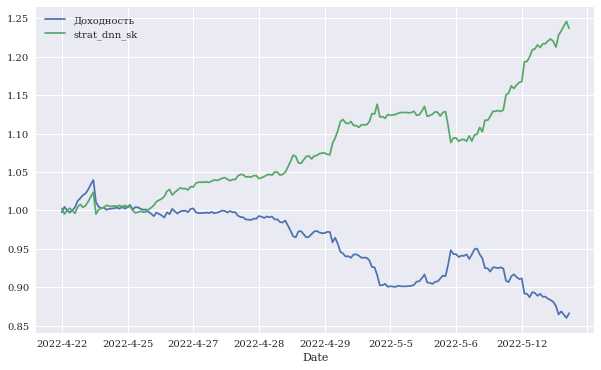

In [35]:
data[['Доходность', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [36]:
pickle.dump(model, open('algorithm_MLPClassifier.pkl', 'wb')) # сохраняем модель в файл, который будет храниться в той же папке

# Загрузка сохранённого объекта модели

In [37]:
algorithm = pickle.load(open('algorithm_MLPClassifier.pkl', 'rb')) # загружаем модель из сохранённого файла

# Запуск алгоритма в режиме реального времени с периодическим обновлением данных

In [38]:
# разобраться с ебучим циклом он сука не работает. Признаком его работы должно быть появление файла signal
# заебись, вроде работает
while True:
    struct = time.localtime()
    if struct.tm_sec == 40:
        # загрузка данных из CSV-файла
        # Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
        # Если задана последовательность INT / STR, используется многоиндекс.
        # Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
        # например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
        # Функция читает файл, в котором данные о последней свече находятся в первой строке 
        raw = pd.read_csv('c:\SBERBANK\QUIK_x64\lua\SiM2\Data\SiM2_Data.csv', index_col=0, parse_dates=False)
        reverse_raw1 = raw[:200] # реверс набора данных
        reverse_raw = reverse_raw1[::-1]
        symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close
        m5_close = reverse_raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием
        # формирование подмножества данных и исключение нечисловых значений (NaN))
        data = (pd.DataFrame(m5_close).dropna())
        # расчёт логарифмической доходности
        data['Доходность'] = np.log(data/data.shift(1))
        # всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
        data.dropna(inplace=True)
        # Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
        # Функция astype() преобразует в указанный тип данных, в данном случае int
        data['Направление'] = np.sign(data['Доходность']).astype(int)
        features = data['Направление'].iloc[-(lags + 1):-1]
        features = features.values.reshape(1, -1)
        #model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)
        #%time model.fit(features)
        signal = model.predict(features)[0]
        f = open('c:\SBERBANK\QUIK_x64\lua\SiM2\Signal_and_transaction\signal.txt', 'w') # вместо а+ лучше поставить w или w+, т.к. дозапись необязательна
        f.write(str(signal)) # секунды убрать, мешать будут и перевод строки
        f.close()
        continue
    else:
        continue
        

KeyboardInterrupt: 